In [ ]:
import numpy as np
from libero.libero import benchmark, get_libero_path
from libero.libero.envs import OffScreenRenderEnv
import os
from IPython.display import display
from PIL import Image
from utils_my import add_camera_jitter_and_blur, add_lighting_effect, extract_camera_images
import matplotlib.pyplot as plt
from pylab import mpl
 
# 设置中文显示字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]

In [ ]:
benchmark_dict = benchmark.get_benchmark_dict()
task_suite_name = "lift_and_place" # can also choose libero_spatial, libero_object, etc.
task_suite = benchmark_dict[task_suite_name]()

# retrieve a specific task
task_id = 0
task = task_suite.get_task(task_id)
task_name = task.name
task_description = task.language
task_bddl_file = os.path.join(get_libero_path("bddl_files"), task.problem_folder, task.bddl_file)
print(f"[info] retrieving task {task_id} from suite {task_suite_name}, the " + \
      f"language instruction is {task_description}, and the bddl file is {task_bddl_file}")

# step over the environment
env_args = {
    "bddl_file_name": task_bddl_file,
    "camera_heights": 256,  # 增加相机分辨率
    "camera_widths": 256,   # 增加相机分辨率
    "scene_properties": {
        "floor_style": "light-gray",  # 自定义地板样式
        "wall_style": "flower",  # 自定义墙壁样式
    },
    "modify": True,
    "offset": 0.04,
}
env = OffScreenRenderEnv(**env_args)
env.seed(1)
state = env.sim.get_state().flatten()
print("state", state.shape)

obs = env.reset()
# 显示初始场景图像
display(Image.fromarray(obs["agentview_image"][::-1]))
init_states = task_suite.get_task_init_states(task_id) # for benchmarking purpose, we fix the a set of initial states
init_state_id = 0
env.set_init_state(init_states[init_state_id])

dummy_action = [0.] * 7
for step in range(1):
    obs, reward, done, info = env.step(dummy_action)
    original_image = obs["agentview_image"][::-1]
    # 添加光源效果
    image_with_light = add_lighting_effect(
        original_image,
        light_position='top_left', 
        intensity=0.8
    )
    
    # 添加相机抖动和运动模糊
    final_image = add_camera_jitter_and_blur(
        image_with_light,
        max_translation=3,
        max_rotation=2,
        blur_kernel_size=15,
        blur_intensity=3
    )
    
    # 创建一个大图来容纳所有图片
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))  # 增加 figsize 以提高分辨率
    
    # 显示原始图片
    axes[0].imshow(original_image)
    axes[0].set_title('背景变化', fontsize=28)  # 增加标题字体大小
    axes[0].axis('off')
    
    # 显示添加光源后的图片
    axes[1].imshow(image_with_light)
    axes[1].set_title('背景、亮度变化，光源在左上角', fontsize=28)  # 增加标题字体大小
    axes[1].axis('off')
    
    # 显示最终效果
    axes[2].imshow(final_image)
    axes[2].set_title('背景、亮度变化和相机抖动', fontsize=28)  # 增加标题字体大小
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.savefig('visualization_results.png', dpi=300, bbox_inches='tight')
    plt.close()
env.close()

### 2.1 This is the code for observing the different init states.

[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[info] retrieving task 0 from suite libero_object, the language instruction is pick up the alphabet soup and place it in the basket, and the bddl file is /home/ljr/embodied/LIBERO/libero/libero/./bddl_files/libero_object/pick_up_the_alphabet_soup_and_place_it_in_the_basket.bddl
problem_info {'problem_name': 'libero_floor_manipulation', 'domain_name': 'robosuite', 'language_instruction': 'pick the alphabet soup and place it in the basket'}
TASK_MAPPING {'libero_tabletop_manipulation': <class 'libero.libero.envs.problems.libero_tabletop_manipulation.Libero_Tabletop_Manipulation'>, 'libero_coffee_table_manipulation': <class 'libero.libero.envs.problems.libero_coffee_table_manipulation.Libero_Coffee_Table_Manipulation'>, 'libero_floor_manipulation': <class 'libero.libero.envs.problems.libero_floor_manipulation.Libero_Floor_Manipulation'>, 'libero_study_tabletop_manipulation': <class 'libero.libero.envs.problems.libero_study_tabletop_m

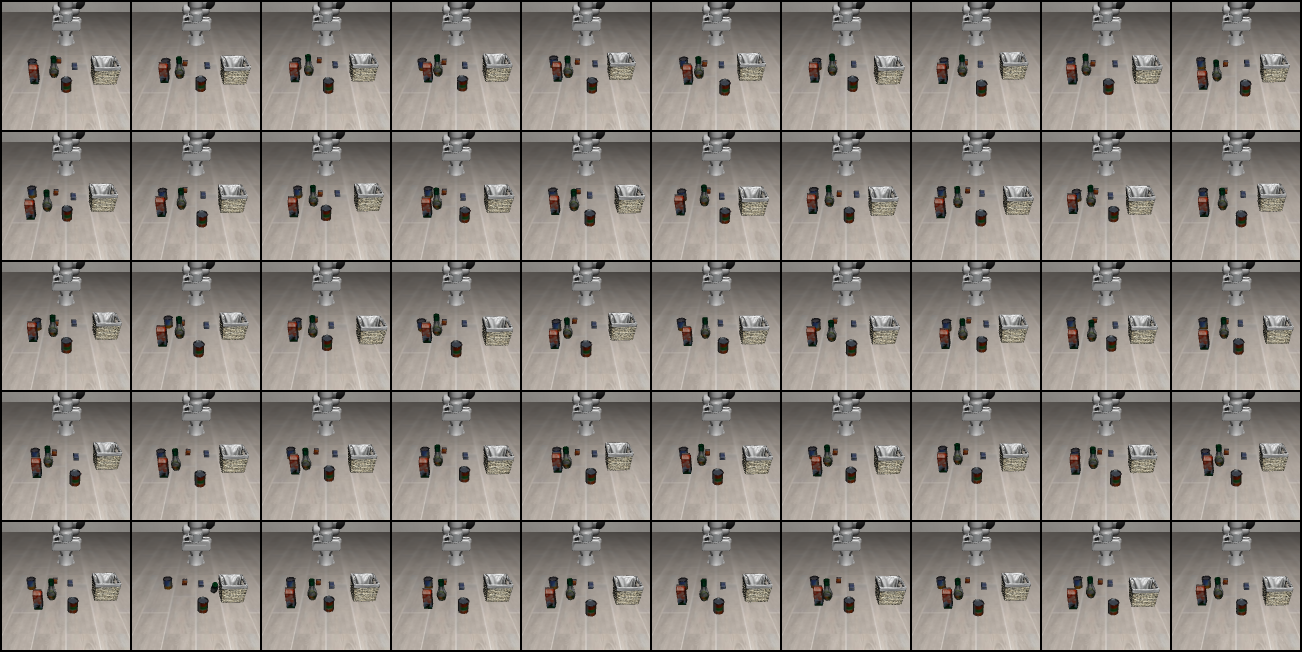

In [31]:
from libero.libero.envs import OffScreenRenderEnv
from IPython.display import display
from PIL import Image

import torch
import torchvision

# task_id is the (task_id + 1)th task in the benchmark
benchmark_dict = benchmark.get_benchmark_dict()
task_suite_name = "libero_object" # can also choose libero_spatial, libero_object, etc.
task_suite = benchmark_dict[task_suite_name]()

# retrieve a specific task
task_id = 0
task = task_suite.get_task(task_id)
task_name = task.name
task_description = task.language
task_bddl_file = os.path.join(get_libero_path("bddl_files"), task.problem_folder, task.bddl_file)
print(f"[info] retrieving task {task_id} from suite {task_suite_name}, the " + \
      f"language instruction is {task_description}, and the bddl file is {task_bddl_file}")

env_args = {
    "bddl_file_name": task_bddl_file,
    "camera_heights": 128,
    "camera_widths": 128
}

env = OffScreenRenderEnv(**env_args)


# init_states = task_suite.get_task_init_states(task_id)
init_states = torch.load("/home/ljr/embodied/LIBERO/libero/libero/init_files/libero_object/pick_up_the_alphabet_soup_and_place_it_in_the_basket.test_init")

# Fix random seeds for reproducibility
env.seed(0)

def make_grid(images, nrow=8, padding=2, normalize=False, pad_value=0):
    """Make a grid of images. Make sure images is a 4D tensor in the shape of (B x C x H x W)) or a list of torch tensors."""
    grid_image = torchvision.utils.make_grid(images, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value).permute(1, 2, 0)
    return grid_image

images = []
env.reset()
for eval_index in range(len(init_states)):
    env.set_init_state(init_states[eval_index])

    for _ in range(5):
        obs, _, _, _ = env.step([0.] * 7)
    images.append(torch.from_numpy(obs["agentview_image"]).permute(2, 0, 1))

# # images = torch.stack(images, dim=0).permute(0, 3, 1, 2)
# print(images.shape)
grid_image = make_grid(images, nrow=10, padding=2, pad_value=0)
display(Image.fromarray(grid_image.numpy()[::-1]))
env.close()

In [ ]:
import numpy as np
from libero.libero.utils.bddl_generation_utils import get_xy_region_kwargs_list_from_regions_info
from libero.libero.utils.mu_utils import register_mu, InitialSceneTemplates
from libero.libero.utils.task_generation_utils import register_task_info, generate_bddl_from_task_info

@register_mu(scene_type="floor")
class lift_and_place(InitialSceneTemplates):
    def __init__(self):
        # 定义固定物体和可移动物体的数量
        fixture_num_info = {
            "floor": 1,
        }

        object_num_info = {
            "alphabet_soup": 1,
            "basket": 1,
            "salad_dressing": 1,
            "cream_cheese": 1,
            "milk": 1,
            "bbq_sauce": 1,
            "butter": 1,
            "orange_juice": 1,
        }

        super().__init__(
            workspace_name="floor",
            fixture_num_info=fixture_num_info,
            object_num_info=object_num_info
        )

    def define_regions(self):
        # 定义basket区域
        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[0.0, 0.26],
                region_name="bin_region",
                target_name=self.workspace_name,
                region_half_len=0.01
            )
        )

        # 定义目标物体区域
        self.regions.update(
            self.get_region_dict(
                region_centroid_xy=[-0.12, -0.24],
                region_name="target_object_region",
                target_name=self.workspace_name,
                region_half_len=0.025
            )
        )

        # 定义其他物体的区域
        other_objects_positions = [
            [0.05, -0.1],
            [-0.15, 0.06],
            [0.1, -0.2],
            [0.15, 0.03],
            [-0.2, -0.08],
            [-0.3, 0.09]
        ]

        for i, pos in enumerate(other_objects_positions):
            self.regions.update(
                self.get_region_dict(
                    region_centroid_xy=pos,
                    region_name=f"other_object_region_{i}",
                    target_name=self.workspace_name,
                    region_half_len=0.025
                )
            )

        self.xy_region_kwargs_list = get_xy_region_kwargs_list_from_regions_info(self.regions)

    @property
    def init_states(self):
        states = [
            ("On", "alphabet_soup_1", "floor_target_object_region"),
            ("On", "salad_dressing_1", "floor_other_object_region_0"),
            ("On", "cream_cheese_1", "floor_other_object_region_1"),
            ("On", "milk_1", "floor_other_object_region_2"),
            ("On", "bbq_sauce_1", "floor_other_object_region_3"),
            ("On", "butter_1", "floor_other_object_region_4"),
            ("On", "orange_juice_1", "floor_other_object_region_5"),
            ("On", "basket_1", "floor_bin_region"),
        ]
        return states

def main():
    # 注册任务信息
    scene_name = "lift_and_place"
    language = "Pick the butter and place it in the basket"
    
    register_task_info(
        language,
        scene_name=scene_name,
        objects_of_interest=["butter_1", "basket_1"],
        goal_states=[("In", "butter_1", "basket_1_contain_region")]
    )

    # 生成BDDL文件
    bddl_file_path = "output/bddl_files"  # 指定输出路径
    bddl_file_names, failures = generate_bddl_from_task_info(folder=bddl_file_path)
    
    print("生成的BDDL文件:", bddl_file_names)
    if failures:
        print("生成失败的任务:", failures)
    from libero.libero.envs import OffScreenRenderEnv
    from IPython.display import display
    from PIL import Image


    env_args = {
        "bddl_file_name": bddl_file_names[0],
        "camera_heights": 256,
        "camera_widths": 256
    }

    env = OffScreenRenderEnv(**env_args)
    obs = env.reset()
    display(Image.fromarray(obs["agentview_image"][::-1]))
if __name__ == "__main__":
    main()

In [23]:
import torch
import numpy as np

q1 = torch.load("/home/ljr/embodied/LIBERO/libero/libero/init_files/libero_object/pick_up_the_alphabet_soup_and_place_it_in_the_basket.test_init")
print(f"q1类型: {type(q1)}")
print(f"q1数据类型: {q1.dtype}")
# print(f"q1数据精度: {np.finfo(q1.dtype)}")
print(q1[5] - q1[14])

q2 = torch.load("/home/ljr/embodied/LIBERO/libero/libero/init_files/lift_and_place/pick_the_alphabet_soup_and_place_it_in_the_basket.init")
print(f"q2类型: {type(q2)}")
print(f"q2数据类型: {q2.dtype}")
print(f"q2数据精度: {np.finfo(q2.dtype)}")
print(q2[0] - q2[2])

q1类型: <class 'torch.Tensor'>
q1数据类型: torch.float64
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  2.7756e-17,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  2.5897e-02, -3.6362e-03,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  7.8165e-04,  1.2363e-03,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  2.7057e-03, -1.5571e-03,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  3.0693e-03,  7.7822e-03,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,


In [ ]:
import h5py
from PIL import Image
import os
import numpy as np

# 打开 HDF5 文件
import torch
import numpy as np

file_path = "libero/datasets/lift_and_place/pick_the_butter_and_place_it_in_the_basket_demo.hdf5"
output_path = "/home/ljr/embodied/LIBERO/libero/libero/init_files/lift_and_place/pick_the_butter_and_place_it_in_the_basket.init"  # 修改保存路径

states_list = []

with h5py.File(file_path, "r") as f:
    # 遍历文件结构
    num_demos = 0
    for episode_name in f.keys():
        episode = f[episode_name]
        #print(f"Episode: {episode_name}")
        for group_name in episode.keys():
            #print(f"  Group: {group_name}")
            # 打印states数据
            if "states" in episode[group_name]:
                states_data = episode[group_name]["states"][:]
                # print(f"    States data for {group_name}:")
                # print(states_data.shape)
                # print(states_data[0])
                # print("\n")
                states_list.append(states_data[0])
                num_demos += 1

    tmp = np.array(states_list)
    print("Shape of tmp:", tmp.shape)
    torch.save(tmp, output_path)
    print(f"Saved states_data[0] to {output_path} in torch format.")

In [ ]:
extract_camera_images("/home/ljr/embodied/LIBERO/libero/libero/../datasets/lift_and_place/flip_the_basket_upside_down_demo.hdf5", "/home/ljr/embodied/LIBERO/video_my_upside_down")